In [ ]:
# Install necessary libraries
!pip install seaborn matplotlib

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.3min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 3.3min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 3.3min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 3.3min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 3.4min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 3.3min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 4.1min
[CV] END ......................C=0.1, gamma=auto

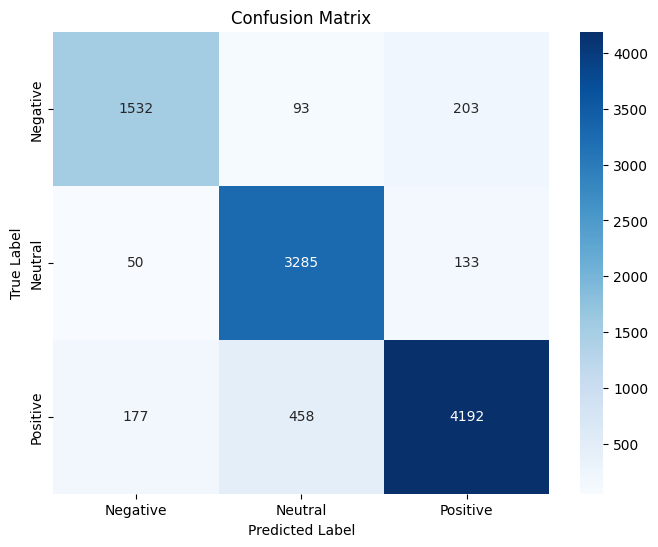

AUC: 0.9609147939141883


In [ ]:
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to save the DataFrame to a new CSV file
def save_to_csv(df, output_filename):
    df.to_csv(output_filename, index=False)
    print(f"Processed data saved to {output_filename}")

# Load the preprocessed data
file_path = '/content/10Benzema20Neymar26RonaldoUPDATED.csv'
data = pd.read_csv(file_path, low_memory=False)

# Specify the tokenized text column in your DataFrame
text = 'preprocessed_text_tokenized'

# Function to calculate polarity and assign labels
def get_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the sentiment analysis function to the 'text_data' column and create a new 'polarity' column
data['polarity'] = data[text].apply(get_polarity)

# Assign labels based on polarity
data['polarity_label'] = data['polarity'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
data['polarity_label'] = data['polarity_label'].map({'negative': -1,'neutral': 0, 'positive': 1})

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)  # You can adjust max_features as needed
X = tfidf.fit_transform(data['preprocessed_text_tokenized'])
y = data['polarity_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM model with GridSearchCV
svm_model = SVC()
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_estimator_)

# Create the model with the best parameters
svm_best = SVC(C=10, gamma='scale', kernel='linear', probability=True)

# Train the model
svm_best.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_best.predict(X_test)

# Save the test predictions data
test_predictions_df = pd.DataFrame({'Text': data.loc[y_test.index, text],
                                    'Actual_Labels': y_test,
                                    'Predicted_Labels': y_pred})
save_to_csv(test_predictions_df, 'SVM_test_predictions.csv')

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print a classification report to see precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the AUC using the one-vs-rest (OvR) strategy
y_prob = svm_best.predict_proba(X_test)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("AUC:", auc)

In [2]:
import pandas as pd

# Read the test predictions file
data = pd.read_csv("/content/SVM_test_predictions.csv")

# Extract the "Predicted_Labels" column
predicted_labels = data["Predicted_Labels"]

# Count the occurrences of each label
positive_count = (predicted_labels == 1).sum()
negative_count = (predicted_labels == -1).sum()
neutral_count = (predicted_labels == 0).sum()

# Calculate the percentage of each label category
total_samples = len(predicted_labels)
positive_percentage = (positive_count / total_samples) * 100
negative_percentage = (negative_count / total_samples) * 100
neutral_percentage = (neutral_count / total_samples) * 100

# Display the results
print("Positive Percentage: {:.2f}%".format(positive_percentage))
print("Negative Percentage: {:.2f}%".format(negative_percentage))
print("Neutral Percentage: {:.2f}%".format(neutral_percentage))

Positive Percentage: 44.73%
Negative Percentage: 17.38%
Neutral Percentage: 37.89%
